# Buffer Stock Saving in HARK and dolo
<!-- <p style="text-align: center;"><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></p>
-->

This notebook compares the solutions to a standard buffer stock saving model obtained by the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit and the [dolo](https://github.com/EconForge/dolo) modeling system.

In [1]:
# This cell does some setup and imports generic tools 

Generator=True # Is this notebook the master or is it generated?
# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')
    print('You appear to be running from a terminal')
    print('By default, figures will appear one by one')
    print('Close the visible figure in order to see the next one')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
plt.rc('font', family='serif')
plt.rc('text', usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../../lib')) # REMARKs directory is two down from root 

from HARK.utilities import plotFuncsDer, plotFuncs
from copy import copy, deepcopy

# Define (and create, if necessary) the figures directory "Figures"
if Generator:
    my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.ipynb")) # Find pathname to this file:
    Figures_HARK_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
    Figures_HARK_dir = os.path.join(my_file_path,"/tmp/Figures/") # Uncomment to make figures outside of git path
    if not os.path.exists(Figures_HARK_dir):
        os.makedirs(Figures_HARK_dir)

## [The Problem](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) 

[This paper](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) defines a buffer stock saving model and calibrates parameters:

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PermGroFac}{\Gamma}\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\newcommand{\Rfree}{\mathrm{\mathsf{R}}}\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\newcommand{\DiscFac}{\beta}\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\newcommand{\UnempPrb}{\wp}\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\newcommand{\IncUnemp}{\mu}\IncUnemp$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\newcommand{\PermShkStd}{\sigma_\psi}\PermShkStd$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\newcommand{\TranShkStd}{\sigma_\theta}\TranShkStd$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

For a microeconomic consumer with 'Market Resources' (net worth plus current income) $M_{t}$, end-of-period assets $A_{t}$ will be the amount remaining after consumption of $C_{t}$.  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t}   &=&M_{t}-C_{t}  \label{eq:DBCparts} \\
%B_{t+1}   & = & A_{t} R \notag \\
\end{eqnarray}

The consumer's permanent noncapital income $P$ grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable lognormally distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \PermGroFac \psi_{t+1}
\end{eqnarray}

and actual income is permanent income multiplied by a logormal multiplicative transitory shock, $\mathbb{E}_{t}[\theta_{t+1}]=1$, so that next period's market resources are
\begin{eqnarray}
%M_{t+1} &=& B_{t+1} +P_{t+1}\theta_{t+1},  \notag
M_{t+1} &=& A_{t}R +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, the paper shows that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{eqnarray*}

and the Euler equation for this model is 

\begin{eqnarray*}
c_{t}^{-\rho} & = & R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1})^{-\rho})] \\
0 & = & R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1}/c_{t})^{-\rho})]-1
\end{eqnarray*}


For the purposes of this notebook, the paper's baseline parameterization is changed as follows:

1. The unemployment (zero-income event) shocks are turned off
2. An explicit liqudity constraint is added ($c_{t} \leq m_{t}$)

# Dolo

[Installation instructions](https://github.com/EconForge/dolo/wiki/Installation) for dolo involve a number of dependencies, including the dolo language "dolang."  This notebook assumes all these have been installed.

In [19]:
from dolo import *

Dolo defines models using "model files" whose syntax is specified in the documentation

In [30]:
model_dolo = yaml_import("../models/bufferstock-with-expectations.yaml")
print( model_dolo )


        Model:
        ------
        name: "anonymous"
        type: "dtcc"
        file: "../models/bufferstock-with-expectations.yaml

Equations:
----------

transition
 1  : 1.7554 : m(0) == exp(tran(0)) + ((m(-(1))) - (c(-(1)))) * ((R) / ((Γ) * (exp(perm(0)))))

arbitrage
 1  : -0.8726 : (((R) * (β)) * (((((c(1)) * (exp(perm(0)))) * (Γ)) / (c(0))) ** (-(ρ)))) - (1)

definitions




In [11]:
# Set a maximum value of the market resources ratio m for use in both models
max_m = 1000
model_dolo.data['calibration']['max_m'] = max_m
model_dolo.data['domain']['m'] = [0,'max_m']

# Obtain the decision rule by time iteration
dr = time_iteration(model_dolo,tol=1e-08,verbose=True)

Solving WITH complementarities.
------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------
|   1 |  9.000e-01 |      nan |    0.331 |   5 |
|   2 |  3.623e-02 |    0.040 |    0.397 |   5 |
|   3 |  2.992e-02 |    0.826 |    0.429 |   6 |
|   4 |  3.283e-02 |    1.097 |    0.308 |   3 |
|   5 |  3.785e-02 |    1.153 |    0.656 |   3 |
|   6 |  4.201e-02 |    1.110 |    0.487 |   3 |
|   7 |  4.443e-02 |    1.058 |    0.376 |   3 |
|   8 |  4.380e-02 |    0.986 |    0.331 |   3 |
|   9 |  4.049e-02 |    0.924 |    0.274 |   3 |
|  10 |  4.491e-02 |    1.109 |    0.465 |   3 |
|  11 |  4.733e-02 |    1.054 |    0.270 |   3 |
|  12 |  4.531e-02 |    0.957 |    0.250 |   3 |
|  13 |  4.804e-02 |    1.060 |    0.227 |   3 |
|  14 |  4.940e-02 |    1.028 |    0.222 |   3 |
|  15 |  4.900e-02 |    0.992 |    0.237 |   3 |
|  16 |  5.082e-02 |    1.037 |    0.227 |   3 |
|  17 |  5.086e-02 |    1.001 |    0.

| 166 |  1.402e-03 |    0.865 |    0.099 |   1 |
| 167 |  1.214e-03 |    0.866 |    0.114 |   1 |
| 168 |  1.050e-03 |    0.865 |    0.186 |   1 |
| 169 |  9.089e-04 |    0.865 |    0.089 |   1 |
| 170 |  7.863e-04 |    0.865 |    0.093 |   1 |
| 171 |  6.805e-04 |    0.865 |    0.092 |   1 |
| 172 |  5.888e-04 |    0.865 |    0.091 |   1 |
| 173 |  5.094e-04 |    0.865 |    0.095 |   1 |
| 174 |  4.407e-04 |    0.865 |    0.095 |   1 |
| 175 |  3.813e-04 |    0.865 |    0.094 |   1 |
| 176 |  3.299e-04 |    0.865 |    0.089 |   1 |
| 177 |  2.853e-04 |    0.865 |    0.099 |   1 |
| 178 |  2.468e-04 |    0.865 |    0.090 |   1 |
| 179 |  2.135e-04 |    0.865 |    0.098 |   1 |
| 180 |  1.846e-04 |    0.865 |    0.096 |   1 |
| 181 |  1.597e-04 |    0.865 |    0.092 |   1 |
| 182 |  1.381e-04 |    0.865 |    0.087 |   1 |
| 183 |  1.194e-04 |    0.865 |    0.093 |   1 |
| 184 |  1.033e-04 |    0.865 |    0.169 |   1 |
| 185 |  8.931e-05 |    0.865 |    0.144 |   1 |
| 186 |  7.724e-05 |

# HARK
The HARK tool used here is $\texttt{ConsIndShockModel.py}$.  For an introduction to this module, see the [ConsIndShockModel.ipynb](https://econ-ark.org/notebooks) notebook at the [Econ-ARK](https://econ-ark.org) website.

In [15]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.03
Rfree      = 1.04
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.00
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

from HARK.utilities import plotFuncsDer, plotFuncs
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [16]:
# Create a model identical to the dolo model
# Start with the HARK baseline parameters and modify 
# to be like the dolo model 
base_params_dolo = dict(base_params)
base_params_dolo['BoroCnstArt']  = 0.0    # Liquidity constraint at 0
base_params_dolo['UnempPrb']     = 0      # No point-mass on unemployment state 
base_params_dolo['TranShkCount'] = 5      # Default number of nodes in dolo
base_params_dolo['PermShkCount'] = 5
base_params_dolo['aXtraMax']     = max_m  # Use same maximum
base_params_dolo['aXtraCount']   = 100    # How dense to make the grid
base_params_dolo['DiscFac']      = 0.96
#base_params_dolo['CubicBool']    = False
model_HARK = IndShockConsumerType(**base_params_dolo,cycles=0) # cycles=0 indicates infinite horizon

In [17]:
# Solve the HARK model 
model_HARK.updateIncomeProcess()
model_HARK.solve()
model_HARK.unpackcFunc()

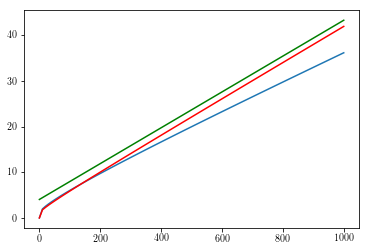

In [18]:
# Plot the results: Green is perfect foresight, red is HARK, black is dolo
tab = tabulate(model_dolo, dr, 'm')
plt.plot(tab['m'],tab['c'])     # This is pretty cool syntax
m = np.ndarray.tolist(np.array(tab.values.tolist())[:,2]) # Is there an easier way to get the points in m?
c_m  = model_HARK.cFunc[0](m)   
# cPF uses the analytical formula for the perfect foresight solution
cPF = (np.array(m)-1+1/(1-PermGroFac/Rfree))*((Rfree-(Rfree * DiscFac)**(1/CRRA))/Rfree)
plt.plot(tab['m'],c_m,color="red")
plt.plot(m,cPF,color="green")